In [1]:
import numpy as np
from data_preparation import *
from utils import *
import csv
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas as pd
from keras.layers import Input,Bidirectional,merge
from keras.layers.core import Dense, Activation, Dropout,Permute,Flatten
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.pooling import MaxPooling1D,AveragePooling1D
from keras.models import load_model
from attention import AttentionLayer
from attention_with_context import AttentionWithContext
from keras.layers.wrappers import TimeDistributed
from keras.utils import CustomObjectScope
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
print('loading data...')
data1 = load_csv(r'cloud_attenuation', 5, "cloud")
data2 = load_csv(r'cloud_attenuation', 4, "cloud")

loading data...


In [18]:
np.max(data1)

1.535982484

In [3]:
day = 288
week = 2016
seq_len = 15
#1=5min, 3=15min, 6=30min, 12=60min
pre_len = 12
#data 1-7
pre_sens_num = 1

#train,test
train_data, train_w, train_d, label, test_data, test_w, test_d, test_l, test_med, test_min\
	= generate_data(data1, data2, seq_len, pre_len, pre_sens_num)

train_data = np.reshape(train_data,(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1))
train_w = np.reshape(train_w,(train_w.shape[0], train_w.shape[1], 1))
train_d = np.reshape(train_d,(train_d.shape[0], train_d.shape[1], 1))

test_data = np.reshape(test_data,(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1))
test_d = np.reshape(test_d,(test_d.shape[0], test_d.shape[1], 1))
test_w = np.reshape(test_w,(test_w.shape[0], test_w.shape[1], 1))

In [4]:
#load model
with CustomObjectScope({'AttentionLayer': AttentionLayer,'AttentionWithContext':AttentionWithContext}):
	json_file = open('model/conv_lstm.json', 'r')
	loaded_model_json = json_file.read()
	json_file.close()
	cnn_lstm_model = model_from_json(loaded_model_json)
	cnn_lstm_model.load_weights("model/model_0025-0.0044.h5", 'r')

NAME:  attention_with_context_1


predict_size: 2016


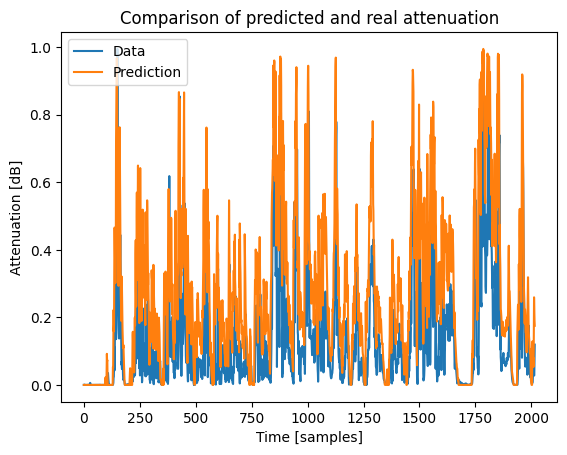

0.9949536868


In [42]:
# start =time.clock()
predicted = predict_point_by_point(cnn_lstm_model, [test_data,test_w,test_d])

pred_med = np.max(predicted) - np.min(predicted)
pred_min = np.min(predicted)

offset = -16
data_snippet = data1[-len(predicted) + offset: offset]
coefficient = -np.max(data1)/np.max(predicted - np.min(predicted))
coefficient = -np.max(data_snippet)/np.max(predicted - np.min(predicted))
scaled_prediction = - coefficient * (predicted  - np.min(predicted))
scaled_prediction = scaled_prediction - np.min(scaled_prediction)

plt.plot(data_snippet)
plt.plot(scaled_prediction)
plt.legend(["Data","Prediction"])
plt.xlabel("Time [samples]")
plt.ylabel("Attenuation [dB]")
plt.title("Comparison of predicted and real attenuation")
plt.show()

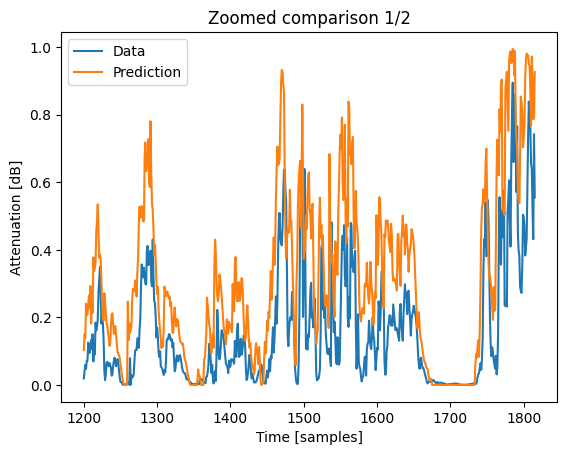

In [41]:
# MAYBE NEED TO LOOK AT THE ALIGNMENT OF THE TWO VECTORS MORE!!!
offset = -16
zoom_left = 1200
zoom_right = -200
x_axis = np.arange(zoom_left,len(scaled_prediction)+zoom_right)
plt.plot(x_axis,data1[-len(scaled_prediction) + offset + zoom_left: offset + zoom_right])
plt.plot(x_axis,scaled_prediction[zoom_left:zoom_right])
plt.legend(["Data","Prediction"])
plt.xlabel("Time [samples]")
plt.ylabel("Attenuation [dB]")
plt.title("Zoomed comparison 1/2")
plt.show()

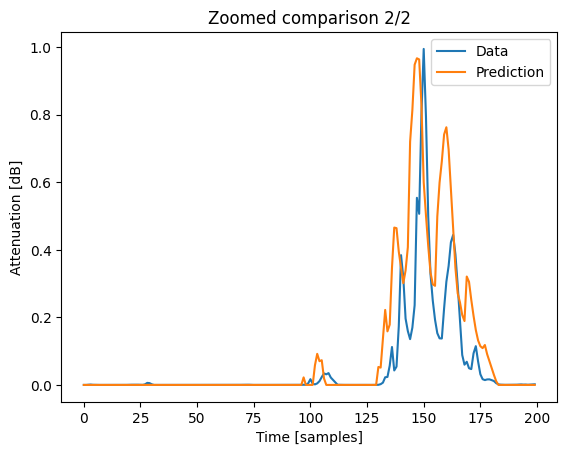

In [40]:
offset = -16
plt.plot(data1[-len(scaled_prediction) + offset:-len(scaled_prediction) + offset + 200])
plt.plot(scaled_prediction[:200])
plt.legend(["Data","Prediction"])
plt.xlabel("Time [samples]")
plt.ylabel("Attenuation [dB]")
plt.title("Zoomed comparison 2/2")
plt.show()

In [36]:
p_real = []
l_real = []
row=2016
for i in range(row):
    p_real.append(predicted[i] * test_med + test_min)
    l_real.append(test_l[i] * test_med + test_min)
p_real = np.array(p_real)
l_real = np.array(l_real)

print ("MAE:", MAE(data_snippet, l_real))
print ("MAPE:", MAPE(p_real, l_real))
print ("RMSE:", RMSE(p_real, l_real))
# end = time.clock()

MAE: 0.12277273945259932
MAPE: inf
RMSE: 0.15934799982981446


d:\Enseeiht\M2S2\Long project\AT_CONV_LSTM\AT-Conv-LSTM\utils.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  x = (abs(pre[i] - true[i])/true[i])


In [33]:
print ("MAE:", MAE(scaled_prediction, data_snippet))
print ("MAPE:", MAPE(scaled_prediction, data_snippet))
print ("RMSE:", RMSE(scaled_prediction, data_snippet))

MAE: 0.15375560839389016
MAPE: nan
RMSE: 0.21146354746529214


d:\Enseeiht\M2S2\Long project\AT_CONV_LSTM\AT-Conv-LSTM\utils.py:28: RuntimeWarning: invalid value encountered in double_scalars
  x = (abs(pre[i] - true[i])/true[i])
